<a href="https://colab.research.google.com/github/emm32449/MCTS-in-Python/blob/main/AddingGame_CPU_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The game is a simple adding game. The game starts at 0 and players can make moves by adding 1, 2, or 3 to the current state. The goal is to reach exactly 10. If a player’s move results in a state exceeding 10, they receive a negative reward. If the state is less than 10, the reward is based on how close the state is to 10. The game resets once it reaches or exceeds 10.

In [1]:
# Assume we have a simple game state
class GameState:
    def __init__(self, state):
        self.state = state

    def __str__(self):
        return str(self.state)

    def get_legal_moves(self):
        return [1, 2, 3]

    def get_initial_state(self):
        return GameState(0)

    def make_move(self, move):
        return GameState(self.state + move)

    def is_terminal(self):
        return self.state >= 10

    def get_reward(self):
        # Give a positive reward if the state is exactly 10
        if self.state == 10:
            return 1
        # Give a negative reward if the state exceeds 10
        elif self.state > 10:
            return -1
        # Give a reward based on how close the state is to 10
        else:
            return 1 - abs(self.state - 10) / 10

    def reset(self):
        self.state = 0

    def copy(self):
        return GameState(self.state)

    def to_array(self):
        return [self.state]


Alpha Go Zero uses a variant of Monte Carlo Tree Search (MCTS) within its training loop. Starting from the root node, which represents the current game state, it traverses the tree until it reaches a leaf node. This game state is passed through the neural network, which outputs a vector of move probabilities and a scalar estimating the expected outcome. The leaf node is then expanded, with each legal move becoming a new child node. The move probabilities output by the network initialize the prior probabilities of selecting each child node in future simulations. The estimated value output by the network is backpropagated up the tree, updating the value estimates of all nodes along the traversed path.

This process is repeated for many simulations, with the Upper Confidence Bound (UCB) formula guiding the selection of nodes during tree traversal. The UCB formula balances exploration and exploitation, taking into account both the value of the node and the prior probability of the node, as well as the number of times the node has been visited. After a large number of simulations, the move leading to the child node with the highest visit count from the root is selected as the next action. This procedure allows AlphaGo Zero to effectively learn a policy favoring high-value actions and a value function predicting the game outcome.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import numpy as np

from torch.nn.utils.rnn import pad_sequence

# Normalize GameState Data
max_state_value = 15  # Initialize with a known max value or a reasonable estimate

def prepare_data(state):
    global max_state_value
    max_state_value = max(max_state_value, max(state))  # Update the max value if the current state is larger
    normalized_state = [s / max_state_value for s in state]
    return normalized_state

class Node:
    def __init__(self, game_state, policy, parent=None, move=None):
        self.game_state = game_state
        self.policy = policy
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.wins = 0

    def __str__(self):
        return f"GameState: {self.game_state}, Move: {self.move}, Visits: {self.visits}, Wins: {self.wins}"

class MCTS:
    def __init__(self, model, root):
        self.model = model
        self.root = root
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.1)

    def choose_action(self, node):
        # Check the mode of the model
        if self.model.training:
            # If the model is in training mode, use probabilistic action selection
            visit_counts = np.array([child.visits for child in node.children])
            visit_dist = visit_counts / visit_counts.sum()
            chosen_action = node.children[np.random.choice(len(node.children), p=visit_dist)].move
        else:
            # If the model is in evaluation mode, use deterministic action selection
            max_visits = max(child.visits for child in node.children)
            chosen_action = [child.move for child in node.children if child.visits == max_visits][0]
        return chosen_action

    def selection(self, node):
        while len(node.children) > 0:
            max_value = -math.inf
            selected_node = None
            for child in node.children:
                if child.visits == 0:  # Stop if the child node has not been visited yet
                    return child
                state_tensor = torch.tensor(child.game_state.to_array(), dtype=torch.float32)
                policy, value = self.model(state_tensor)
                Q = child.wins / child.visits if child.visits != 0 else 0
                U = policy.mean() * math.sqrt(node.visits) / (1 + child.visits)
                node_value = Q + U + child.policy.mean()  # Take the mean of the policy tensor
                if node_value > max_value:
                    max_value = node_value
                    selected_node = child
            node = selected_node
        return node

    def expansion(self, node):
        # Get the list of legal moves from the game state
        legal_moves = node.game_state.get_legal_moves()

        # For each legal move, create a new node and add it to the children of the current node
        for move in legal_moves:
            new_game_state = node.game_state.make_move(move)
            state_tensor = torch.tensor(new_game_state.to_array(), dtype=torch.float32)
            policy, value = self.model(state_tensor)
            child_node = Node(new_game_state, policy, parent=node, move=move)
            node.children.append(child_node)

        return node.children

    def simulation(self, node):
        game_state = node.game_state.copy()
        while not game_state.is_terminal():
            state_tensor = torch.tensor(game_state.to_array(), dtype=torch.float32)
            policy, _ = self.model(state_tensor)
            policy_dist = F.softmax(policy, dim=0).detach().numpy()
            legal_moves = game_state.get_legal_moves()
            move = np.random.choice(legal_moves, p=policy_dist)
            game_state = game_state.make_move(move)
            #print(f"Game state after move: {game_state}")  # Print the game state after each move
        reward = game_state.get_reward()
        #print(f"Terminal game state reached with reward: {reward}")  # Print the reward when a terminal state is reached
        return reward

    def backpropagation(self, node, reward):
        # While node is not None
        while node is not None:
            # Update the visit count of the node
            node.visits += 1

            # Update the win count of the node
            node.wins += reward

            # Move to the parent node
            node = node.parent

    def print_tree(self, node, indent=""):
        print(indent + str(node))
        for child in node.children:
            self.print_tree(child, indent + "  ")

    # Train
    def train(self, states, policies, rewards, epochs):
        # Convert states, policies, and rewards to tensors
        states = torch.tensor(states, dtype=torch.float32)
        policies = torch.tensor(policies, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)

        for _ in range(epochs):
            policy_pred, value_pred = self.model(states)

            policy_loss = F.kl_div(F.log_softmax(policy_pred, dim=1), policies)
            value_loss = F.mse_loss(value_pred.squeeze(), rewards)
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return loss.item()

    # Self Play
    def self_play(self, network, game, game_number, num_simulations):
        states = []
        policies = []
        current_state = game.get_initial_state()
        root = Node(current_state, None)

        for sim in range(num_simulations):
            #print(f"Starting simulation.")
            leaf = self.selection(root)
            children = self.expansion(leaf)
            self.simulation(random.choice(children))
            legal_actions = game.get_legal_moves()
            visit_counts = [child.visits if child.visits > 0 else torch.rand(1).item() for child in root.children]
            policy = torch.zeros(network.policy_head.out_features)  # Initialize a zero vector of length equal to the output size of the policy head
            for action, visit_count in zip(legal_actions, visit_counts):
                policy[action - 1] = visit_count  # Subtract 1 from action to use it as an index
            policy = F.softmax(policy, dim=0)

            action_index = torch.multinomial(policy, 1).item()
            action = root.children[action_index].move
            states.append(prepare_data(current_state.to_array()))
            policies.append(policy.tolist())  # Convert policy tensor to list
            current_state = current_state.make_move(action + 1)  # Add 1 to action to use it as a move
            root = root.children[action_index]

        # Determine the reward based on the final state of the game
        reward = current_state.get_reward()

        return states, policies, reward  # Return policies as a list

class MyReplayBuffer:
    def __init__(self, max_size):
        # Initialize your buffer with a maximum size
        self.max_size = max_size
        self.buffer = []

    def add_transition(self, transition):
        # Add a transition (state, action, reward, next_state) to the buffer
        self.buffer.append(transition)
        if len(self.buffer) > self.max_size:
            self.buffer.pop(0)

    def sample_batch(self, batch_size):
        # Sample a batch of transitions
        return random.sample(self.buffer, batch_size)

class EloRating:
    def __init__(self, initial_rating=1200, k=20):
        self.rating = initial_rating
        self.k = k

    def update(self, score):
        benchmark_rating = 10  # Set this to the desired benchmark performance level
        expected_score = 1 / (1 + 10 ** ((benchmark_rating - self.rating) / 400))
        self.rating += self.k * (score - expected_score)
        return self.rating

Initial Training Loop:

A Replay Buffer helps to break the correlation between consecutive experiences, which is beneficial for the stability of the learning algorithm. The policy is represented implicitly by the actions chosen by the Monte Carlo Tree Search, which uses the neural network’s outputs.

In [4]:
# Create the game and network
game = GameState(0)  # Initialize the game
num_actions = len(game.get_legal_moves())  # Get the number of possible actions
network = PolicyValueResNet(num_actions)  # Initialize the policy-value network
uniform_policy = [1.0 / num_actions] * num_actions  # Initialize a uniform policy
root = Node(game.get_initial_state(), uniform_policy)  # Initialize the root node of the MCTS
mcts = MCTS(network, root)  # Initialize the MCTS with the network and root node
epoch_losses = []  # Initialize a list to store the losses per epoch
elo_ratings = []

# Initialize Elo rating
elo = EloRating()

network.train()  # Set the network to training mode

game_number = 1  # Initialize the game number
optimizer = torch.optim.Adam(network.parameters())  # Initialize the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)  # Initialize the learning rate scheduler

import random

total_games = 0  # Initialize the total number of games played

# Hyperparameters
epochs = 100
num_simulations = 20
# Replay Buffer
max_buffer_size = 1000
replay_buffer = MyReplayBuffer(max_buffer_size)
batch_size = 100
subset_size = 80

for i in range(epochs):
    batch_states, batch_policies, batch_rewards = [], [], []
    batch_losses = []

    for j in range(batch_size):
        # Collect transitions during self-play
        states, policies, reward = mcts.self_play(network, game, game_number, num_simulations)
        for state, policy, r in zip(states, policies, [reward] * len(states)):
            replay_buffer.add_transition((state, policy, r))

        total_games += 1
        #print(f"Game number {total_games} completed in batch {i + 1}")

    # Sample a subset from the buffer
    batch_transitions = replay_buffer.sample_batch(subset_size)
    subset_states, subset_policies, subset_rewards = zip(*batch_transitions)

    # Train the network using the subset
    loss = mcts.train(subset_states, subset_policies, subset_rewards, epochs)
    batch_losses.append(loss)

    avg_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(avg_loss)
    #print(f"Average loss after epoch {i + 1}: {avg_loss}")

    # Adjust learning rate
    scheduler.step()

    # Update Elo rating based on the performance in this epoch
    score = 1 if game.state == 10 else 0 if game.state > 10 else 0.5
    elo.update(score)
    elo_ratings.append(elo.rating)
    #print(f"Elo Rating after epoch {i + 1}: {elo.rating}")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Network:
⌨

Input is a 1D vector rather than a 2D Board or image. Adjust the network to use fully connected layers (nn.Linear) instead of 2D convolutional layers (nn.Conv2d). The idea behind a Residual Block is to introduce a so-called “skip connection” or “shortcut”, which allows the gradient to be directly backpropagated to earlier layers.

During training, the network is updated to make its policy output match the actions selected by the Monte Carlo Tree Search (MCTS), and to make its value output match the final outcome of the simulated games.

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.fc1 = nn.Linear(num_channels, num_channels)
        self.fc2 = nn.Linear(num_channels, num_channels)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        out += x  # Skip connection
        out = F.relu(out)
        return out

class PolicyValueResNet(nn.Module):
    def __init__(self, num_actions):
        super().__init__()
        self.hidden1 = nn.Linear(1, 64)
        self.resblock = ResidualBlock(64)
        self.hidden2 = nn.Linear(64, 64)

        # Policy Head forms probabilities for each action, distribution
        self.policy_head = nn.Linear(64, num_actions)

        # Value Head predicts winner of game from each position, scaler
        self.value_head = nn.Linear(64, 1)

    def forward(self, state):
        x = F.relu(self.hidden1(state))
        x = self.resblock(x)
        x = F.relu(self.hidden2(x))
        policy = F.softmax(self.policy_head(x), dim=-1)
        value = torch.tanh(self.value_head(x))
        return policy, value

Save - AddingGame_MCTS_Model2.pth

In [12]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model, optimizer, game number, average losses per epoch, total games, game state, and root node
torch.save({
    'model_state_dict': network.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'game_number': game_number,
    'epoch_losses': epoch_losses,
    'total_games': total_games,
    'game_state': game,
    'root_node': root,
    'elo_rating': elo.rating,
    'elo_ratings': elo_ratings
}, '/content/drive/My Drive/MCTS in Python/AddingGame_MCTS_Model2.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load & Continue - AddingGame_MCTS_Model2.pth

In [10]:
from google.colab import drive
drive.mount('/content/drive')

game = GameState(0)  # Initialize the game
num_actions = len(game.get_legal_moves())  # Get the number of possible actions
network = PolicyValueResNet(num_actions)  # Initialize the policy-value network
uniform_policy = [1.0 / num_actions] * num_actions  # Initialize a uniform policy
root = Node(game.get_initial_state(), uniform_policy)  # Initialize the root node of the MCTS
mcts = MCTS(network, root)  # Initialize the MCTS with the network and root node

optimizer = torch.optim.Adam(network.parameters())  # Initialize the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)  # Initialize the learning rate scheduler

# Load the saved model, optimizer, scheduler, and other necessary variables from the checkpoint
checkpoint = torch.load('/content/drive/My Drive/MCTS in Python/AddingGame_MCTS_Model2.pth')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
game_number = checkpoint['game_number']
epoch_losses = checkpoint['epoch_losses']
total_games = checkpoint['total_games']
game = checkpoint['game_state']
root = checkpoint['root_node']
elo_rating = checkpoint['elo_rating']
elo_ratings = checkpoint['elo_ratings']

elo = EloRating(initial_rating=elo_rating)

# Continue training
network.train()  # Ensure the network is in training mode
epochs = 500
num_simulations = 50
max_buffer_size = 1000
replay_buffer = MyReplayBuffer(max_buffer_size)  # Initialize the replay buffer
batch_size = 100
subset_size = 80

for i in range(epochs):
    batch_states, batch_policies, batch_rewards = [], [], []
    batch_losses = []
    for j in range(batch_size):
        # Perform self-play and add the resulting states, policies, and rewards to the batch
        states, policies, reward = mcts.self_play(network, game, game_number, num_simulations)
        for state, policy, r in zip(states, policies, [reward] * len(states)):
            replay_buffer.add_transition((state, policy, r))  # Add transitions to the replay buffer
        total_games += 1
        #print(f"Game number {total_games} completed in batch {i + 1}")
    # Sample a random subset of transitions from the replay buffer
    batch_transitions = replay_buffer.sample_batch(subset_size)
    subset_states, subset_policies, subset_rewards = zip(*batch_transitions)
    # Train the network on the subset and calculate the loss
    loss = mcts.train(subset_states, subset_policies, subset_rewards, epochs)
    batch_losses.append(loss)
    avg_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(avg_loss)
    #print(f"Average loss after epoch {i + 1}: {avg_loss}")
    scheduler.step()  # Update the learning rate

    # Update Elo rating based on the performance in this epoch
    score = 1 if game.state == 10 else 0 if game.state > 10 else 0.5
    elo.update(score)
    elo_ratings.append(elo.rating)
    #print(f"Elo Rating after epoch {i + 1}: {elo.rating}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Plots for Loss and Elo Rating:

The Elo rating system is a tool to measure performance and guide learning. A decreasing Elo rating could mean that the model is exploring the game space and making necessary mistakes to learn. Over time, as the model learns from these mistakes, its performance and Elo rating should start to improve. If the Elo rating continues to decrease over a long period of time, it might be worth revisiting your training process, learning rate, or the design of your model. It could be that the model is stuck in a suboptimal strategy, or that the learning rate is too high or too low.

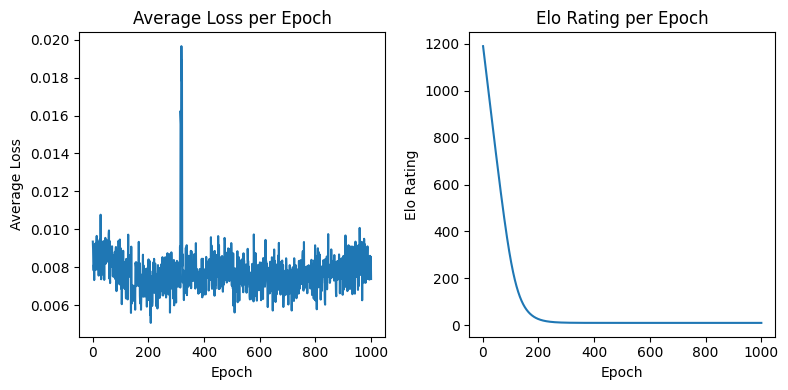

In [13]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Plot the average losses per epoch
axs[0].plot(range(1, len(epoch_losses) + 1), epoch_losses)  # Use epoch numbers as x-axis
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Average Loss')
axs[0].set_title('Average Loss per Epoch')

# Plot the Elo ratings per epoch
# Assuming elo_ratings is a list of Elo ratings after each epoch
axs[1].plot(range(1, len(elo_ratings) + 1), elo_ratings)  # Use epoch numbers as x-axis
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Elo Rating')
axs[1].set_title('Elo Rating per Epoch')

# Display the plots
plt.tight_layout()
plt.show()

Play, Eval() - AddingGame_MCTS_Model2.pth

In [ ]:
# Initialize a list to store the results of each game
rewards = []
elo = EloRating()

from google.colab import drive
drive.mount('/content/drive')

# Load the model and optimizer
checkpoint = torch.load('/content/drive/My Drive/MCTS in Python/AddingGame_MCTS_Model2.pth')
network.load_state_dict(checkpoint['model_state_dict'])
mcts.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to evaluation mode
network.eval()

# Simulate 10 games
num_games = 10
num_sims = 15
elo_ratings = []  # Initialize a list to store the Elo ratings

for i in range(num_games):
    print(f"Game {i + 1}:")

    # Initialize the game and the root node
    game_state = game.get_initial_state()
    root = Node(game_state, None)

    # Make sure that the MCTS and the root node persist throughout each game
    mcts = MCTS(network, root)

    while not game_state.is_terminal():
        # Perform MCTS simulations from the root
        for _ in range(num_sims):
            leaf = mcts.selection(root)
            children = mcts.expansion(leaf)
            reward = mcts.simulation(random.choice(children))
            mcts.backpropagation(leaf, reward)

        # Choose the action that leads to the most visited child node
        action = mcts.choose_action(root)

        # Apply the action to get the next state
        game_state = game_state.make_move(action)

        print(f"Action taken: {action}")

    print(f"Final reward: {reward}")

    # Append the result of the game to the rewards list
    rewards.append(reward)

    # Update Elo rating based on the performance in this game
    score = 1 if reward == 1 else 0 if reward == -1 else 0.5
    elo.update(score)
    elo_ratings.append(elo.rating)  # Append the updated Elo rating to the list

    print(f"Elo rating after game {i + 1}: {elo.rating}")

# Calculate the win rate
win_rate = rewards.count(1) / num_games

print(f"Win rate: {win_rate}")

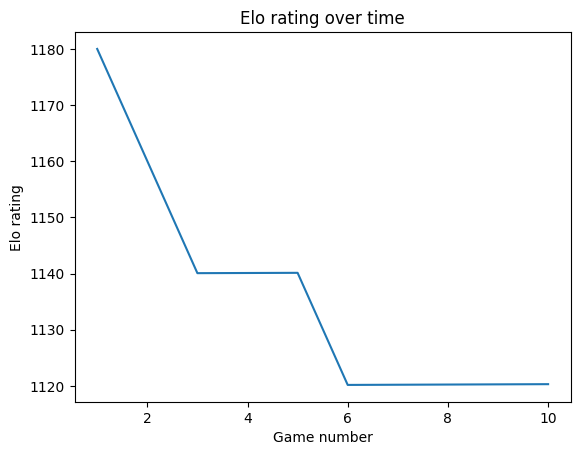

In [15]:
# Plot Elo rating over time
plt.plot(range(1, num_games + 1), elo_ratings)
plt.xlabel('Game number')
plt.ylabel('Elo rating')
plt.title('Elo rating over time')
plt.show()